## Study population

**71916** participants enrolled in the NHANES 1999 - 2012.

**24789** participants who aged 40 or over at the baseline

- Subjects who didn't receive physical examination (n = 1380)
- Subjects without mortality data (n = 34 )
- Subjects missing SII value at basline (n = 2564 )

Study population (N = **22197**)
- Endpoint December 2013

## Conclusion

- Age, BMI, gender, race, smoking status, alcohol drinking status, and physical activity classification are all significantly associated with the Systemic Immune-Inflammation Index (SII) in the analyzed population

- age, bmi, gender, race, and smoking status have higher coefficients compared to their counterparts, indicating a potential association with higher SII values. 

- alcohol drinking status and physical activity have lower coefficients compared to their counterparts, indicating a potential association with lower SII values.
 
- Subjects in the high SII subgroup had higher risks of total mortality **[ HR (95% CI) = 1.14 (1.07 - 1.22) ]**

- Subjects in the high SII subgroup had higher risks of CVD mortality **[ HR (95% CI) = 1.08 (0.96 - 1.2) ]**

- For subjects with a high level of SII, physical activity could attenuate a separate **27%** and **33%** risks of total and CVD mortality in the NHANES 1999–2012.

In [296]:
! pip install pandas google-cloud-bigquery lifelines db-dtypes

Defaulting to user installation because normal site-packages is not writeable


In [297]:
import os
import pandas as pd
from lifelines import CoxPHFitter
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery

In [298]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "nhanesgcp-cb4c8ab27256.json"
client = bigquery.Client()

In [434]:
query = """
WITH MortalityData AS (
    SELECT
        respondent_sequence_number,
        CASE
            WHEN ucod_leading = 1.0 THEN 'Diseases of heart'
            WHEN ucod_leading = 2.0 THEN 'Malignant neoplasms'
            WHEN ucod_leading = 3.0 THEN 'Chronic lower respiratory diseases'
            WHEN ucod_leading = 4.0 THEN 'Accidents (unintentional injuries)'
            WHEN ucod_leading = 5.0 THEN 'Cerebrovascular disease'
            WHEN ucod_leading = 6.0 THEN 'Alzheimer’s disease'
            WHEN ucod_leading = 7.0 THEN 'Diabetes mellitus'
            WHEN ucod_leading = 8.0 THEN 'Influenza and pneumonia'
            WHEN ucod_leading = 9.0 THEN 'Nephritis, nephrotic syndrome and nephrosis'
            WHEN ucod_leading = 10.0 THEN 'All other causes (residual)'
            ELSE 'Unknown cause'
        END AS ucod_leading,
        mort_stat,
        permth_exm
    FROM
        `nhanesgcp.nhanes_mort_1999_2018.nhanes_mort`
),
SII_Calculation AS (
    SELECT 
        respondent_sequence_number,
        segmented_neutrophils_num_1000_cell_ul,
        segmented_neutrophils_num_1000_cell_ul,
        lymphocyte_number_1000_cells_ul,
        (segmented_neutrophils_num_1000_cell_ul * platelet_count_1000_cells_ul) / lymphocyte_number_1000_cells_ul AS SII
    FROM 
        `nhanesgcp.dbt.complete_blood_count_with_5_part_differential_whole_blood_laboratory`
),
SII_Stats AS (
    SELECT
        APPROX_QUANTILES(SII, 4) AS quartiles
    FROM
        SII_Calculation
),
SII_Groups AS (
    SELECT
        SII_Calculation.*,
        CASE
            WHEN SII IS NULL THEN NULL
            WHEN SII <= (SELECT quartiles[OFFSET(1)] FROM SII_Stats) THEN 'Low'
            WHEN SII <= (SELECT quartiles[OFFSET(2)] FROM SII_Stats) THEN 'Middle'
            ELSE 'High'
        END AS SII_Group
    FROM
        SII_Calculation
    CROSS JOIN
        SII_Stats
),
PhysicalActivityData AS (
    SELECT
        respondent_sequence_number,
        COALESCE(of_times_did_activity_in_past_30_days * average_duration_of_activity_minutes, 0) AS total_activity_duration_minutes
    FROM
       `nhanesgcp.dbt.physical_activity_individual_activities_questionnaire`
),
BodyMeasurements AS (
    SELECT 
        respondent_sequence_number,
        weight_kg,
        standing_height_cm,
        COALESCE(weight_kg / (standing_height_cm / 100), 0) AS bmi
    FROM 
        `nhanesgcp.dbt.body_measures_examination`
),
AlcoholData AS (
    SELECT
        respondent_sequence_number,
        had_at_least_12_alcohol_drinks_1_yr
    FROM
        `nhanesgcp.dbt.alcohol_use_questionnaire`
),
AlcoholDrinkingStatus AS (
    SELECT
        respondent_sequence_number,
        CASE
            WHEN COALESCE(had_at_least_12_alcohol_drinks_1_yr, 'No') = 'Yes' THEN 'Drinker'
            ELSE 'Non-Drinker'
        END AS alcohol_drinking_status
    FROM
        AlcoholData
),
 SmokingData AS (
    SELECT
        respondent_sequence_number,
        smoked_at_least_100_cigarettes_in_life
    FROM
        `nhanesgcp.dbt.smoking_cigarette_use_questionnaire`
),
SmokingStatus AS (
    SELECT
        respondent_sequence_number,
        CASE
            WHEN COALESCE(smoked_at_least_100_cigarettes_in_life, 'No') = 'Yes' THEN 'Smoker'
            ELSE 'Non-Smoker'
        END AS smoking_status
    FROM
        SmokingData
),
Filtered_Demographics AS (
    SELECT 
        respondent_sequence_number,
        age_in_years_at_screening AS age,
        interview_examination_status,
        gender,
        race_hispanic_origin AS race,
        CASE
    WHEN COALESCE(education_recode_old_version, 'Less Than High School') = 'More Than High School' THEN 'college or above'
    WHEN COALESCE(education_recode_old_version, 'Less Than High School') = 'High School Diploma (including GED)' THEN 'high school'
    ELSE 'Less Than High School'
END AS education_level
    FROM 
        `nhanesgcp.dbt.demographic_variables_sample_weights_demographics`
    WHERE 
        end_year <= 2015
        AND 
        CAST(age_in_years_at_screening AS INT64) >= 40
)
SELECT 
    fd.respondent_sequence_number,
    fd.age,
    fd.gender,
    bm.bmi,
    fd.race,
    fd.education_level,
    ads.alcohol_drinking_status,
    CASE
        
        WHEN ss.smoking_status = "Smoker" THEN "Smoker"
        ELSE "Non-smoker"
    END AS smoking_status,
    
    md.ucod_leading,
    md.mort_stat,
    md.permth_exm,
    sii.SII,
    
    CASE 
        WHEN pa.total_activity_duration_minutes >= 150 THEN 'Physically Active'
        ELSE 'Physically Inactive'
    END AS physical_activity_classification,
    sg.SII_Group
FROM 
    Filtered_Demographics fd
LEFT JOIN
    MortalityData md ON fd.respondent_sequence_number = md.respondent_sequence_number
LEFT JOIN 
    SII_Calculation sii ON fd.respondent_sequence_number = sii.respondent_sequence_number
LEFT JOIN
    PhysicalActivityData pa ON fd.respondent_sequence_number = pa.respondent_sequence_number
    LEFT JOIN 
    BodyMeasurements bm ON fd.respondent_sequence_number = bm.respondent_sequence_number
    LEFT JOIN 
    AlcoholData alcohol ON fd.respondent_sequence_number = alcohol.respondent_sequence_number
    LEFT JOIN 
    AlcoholDrinkingStatus ads ON fd.respondent_sequence_number = ads.respondent_sequence_number
    LEFT JOIN 
    SmokingData smoking ON fd.respondent_sequence_number = smoking.respondent_sequence_number
    LEFT JOIN 
    SmokingStatus ss ON fd.respondent_sequence_number = ss.respondent_sequence_number
    LEFT JOIN
    SII_Groups sg ON fd.respondent_sequence_number = sg.respondent_sequence_number
     WHERE  
      md.mort_stat IS NOT NULL
      AND fd.interview_examination_status = "Both interviewed and MEC examined"
      AND sii.SII IS NOT NULL

ORDER BY
    fd.respondent_sequence_number;
"""

In [435]:
df = client.query(query).to_dataframe()
df.head()

,respondent_sequence_number,age,gender,bmi,race,education_level,alcohol_drinking_status,smoking_status,ucod_leading,mort_stat,permth_exm,SII,physical_activity_classification,SII_Group
0,2,77.0,Male,43.333333,Non-Hispanic White,college or above,Non-Drinker,Non-smoker,Alzheimer’s disease,1,177,682.125,Physically Inactive,High
1,5,49.0,Male,51.878856,Non-Hispanic White,college or above,Non-Drinker,Non-smoker,Unknown cause,0,244,294.500,Physically Active,Low
2,5,49.0,Male,51.878856,Non-Hispanic White,college or above,Non-Drinker,Non-smoker,Unknown cause,0,244,294.500,Physically Active,Low
3,5,49.0,Male,51.878856,Non-Hispanic White,college or above,Non-Drinker,Non-smoker,Unknown cause,0,244,294.500,Physically Inactive,Low
4,5,49.0,Male,51.878856,Non-Hispanic White,college or above,Non-Drinker,Non-smoker,Unknown cause,0,244,294.500,Physically Inactive,Low


## Multivariable Linear Regression

In [437]:
data =  df

# using Low as ref (for cox model)
df['SII_Group'] = pd.Categorical(df['SII_Group'], categories=['Low', 'Middle', 'High'], ordered=True)

# using inactive as ref
df['physical_activity_classification'] = pd.Categorical(df['physical_activity_classification'], categories=['Physically Inactive', 'Physically Active'], ordered=True)

# using non drinker as ref
df['alcohol_drinking_status'] = pd.Categorical(df['alcohol_drinking_status'], categories=['Non-Drinker', 'Drinker'], ordered=True)

independent_vars = ['age', 'bmi']
categorical_vars = ['gender', 'race', 'smoking_status', 'alcohol_drinking_status', 'physical_activity_classification', 'education_level']
dependent_var = 'SII'

data = pd.get_dummies(data, columns=categorical_vars, dtype=float) 

data[independent_vars] = data[independent_vars].astype(float)
data[dependent_var] = data[dependent_var].astype(float)

X = sm.add_constant(data[independent_vars + 
                          data.columns[data.columns.str.startswith('gender_')].tolist() + 
                          data.columns[data.columns.str.startswith('race_')].tolist() + 
                          data.columns[data.columns.str.startswith('smoking_status_')].tolist() + 
                          data.columns[data.columns.str.startswith('alcohol_drinking_status_')].tolist() + 
                          data.columns[data.columns.str.startswith('physical_activity_classification_')].tolist() +
                          data.columns[data.columns.str.startswith('education_level_')].tolist()  # Add education_level dummies here
                         ])

model = sm.OLS(data[dependent_var], X)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    SII   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     63.05
Date:                Wed, 13 Mar 2024   Prob (F-statistic):          4.02e-152
Time:                        21:31:21   Log-Likelihood:            -2.1230e+05
No. Observations:               28571   AIC:                         4.246e+05
Df Residuals:                   28558   BIC:                         4.247e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

## Multivariable Linear Regression Interpretation

These results suggest that 

* age (coeff = 1.3347,  p-value < 0.001), \
This indicates that for each one-unit increase in age, the SII increases by approximately 1.33 units, holding all other variables constant.

* bmi (coeff =  -0.7255,  p-value < 0.001) , \
This suggests that for each one-unit increase in BMI, the SII decreases by approximately 0.73 units, holding all other variables constant.

* gender ( male coeff = 59.7812 , female coeff = 85.4562, p-value < 0.001 ),\
race, \
This indicates that females have a significantly higher SII compared to males.

- 'smoking_status_Non-smoker' has a coefficient of 57.7071, while 'smoking_status_Smoker' has a higher coefficient of 87.5302.
This suggests that smokers tend to have a higher SII compared to non-smokers. 

- **'alcohol_drinking_status_Drinker'** and **'physical_activity_classification_Physically Active**' have lower coefficients compared to their counterparts, indicating a potential association with lower SII values. 

- 'high school education or below' tend to have a lower SII compared to those with 'college education or above'. The coefficients for high school and below high school education levels are 62.17 and 39.87, respectively (p-value < 0.001).


**are all significantly associated with the Systemic Immune-Inflammation Index (SII)** in the analyzed population.

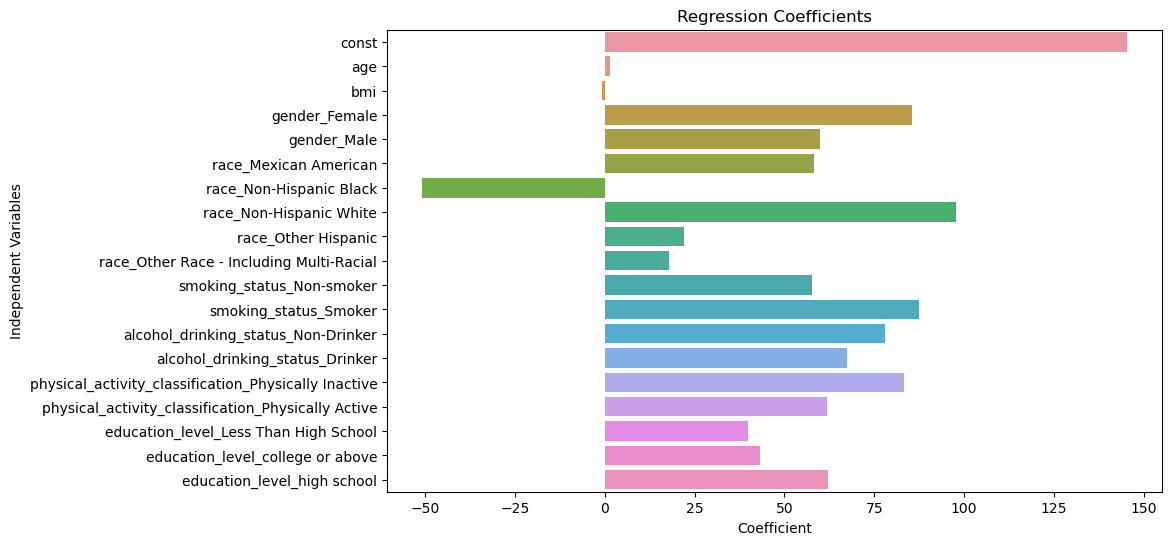

In [438]:
# Coefficient Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=result.params, y=result.params.index)
plt.xlabel('Coefficient')
plt.ylabel('Independent Variables')
plt.title('Regression Coefficients')
plt.show()

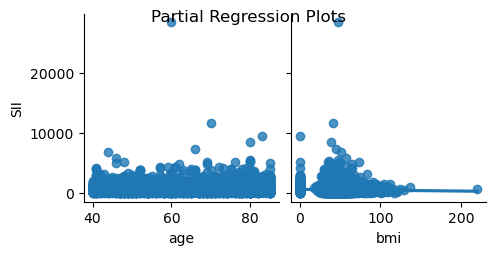

In [410]:
# Partial Regression Plots
sns.pairplot(data=pd.concat([X, data['SII']], axis=1), y_vars=['SII'], x_vars=independent_vars, kind='reg')
plt.suptitle('Partial Regression Plots')
plt.show()

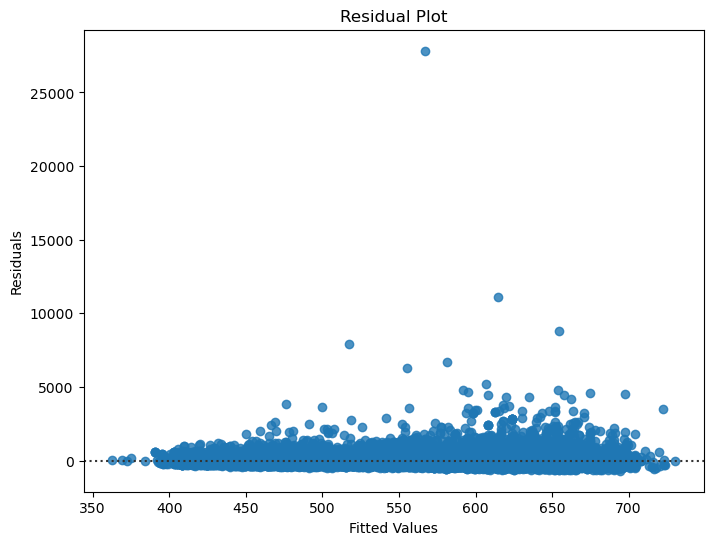

In [411]:
# Residual Plot
plt.figure(figsize=(8, 6))
sns.residplot(x=result.fittedvalues, y=result.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

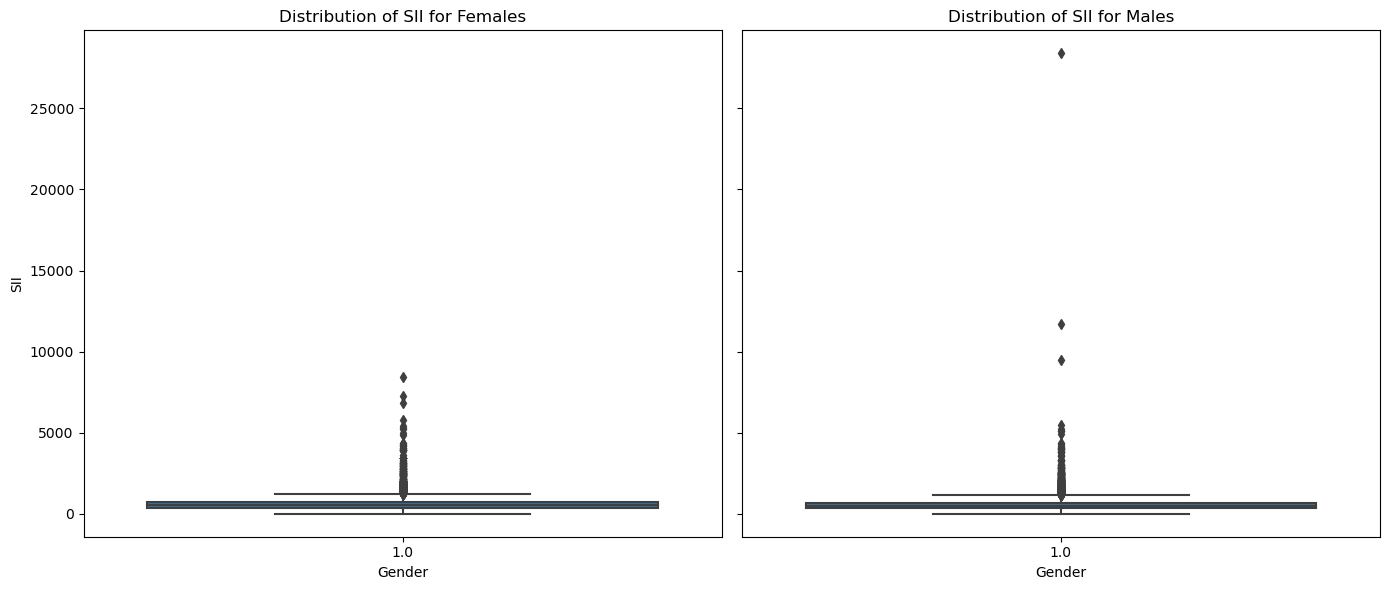

In [412]:
# Grouped Boxplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.boxplot(ax=axes[0], x='gender_Female', y='SII', data=data[data['gender_Female'] == 1])
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('SII')
axes[0].set_title('Distribution of SII for Females')

sns.boxplot(ax=axes[1], x='gender_Male', y='SII', data=data[data['gender_Male'] == 1])
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('')
axes[1].set_title('Distribution of SII for Males')

plt.tight_layout()
plt.show()


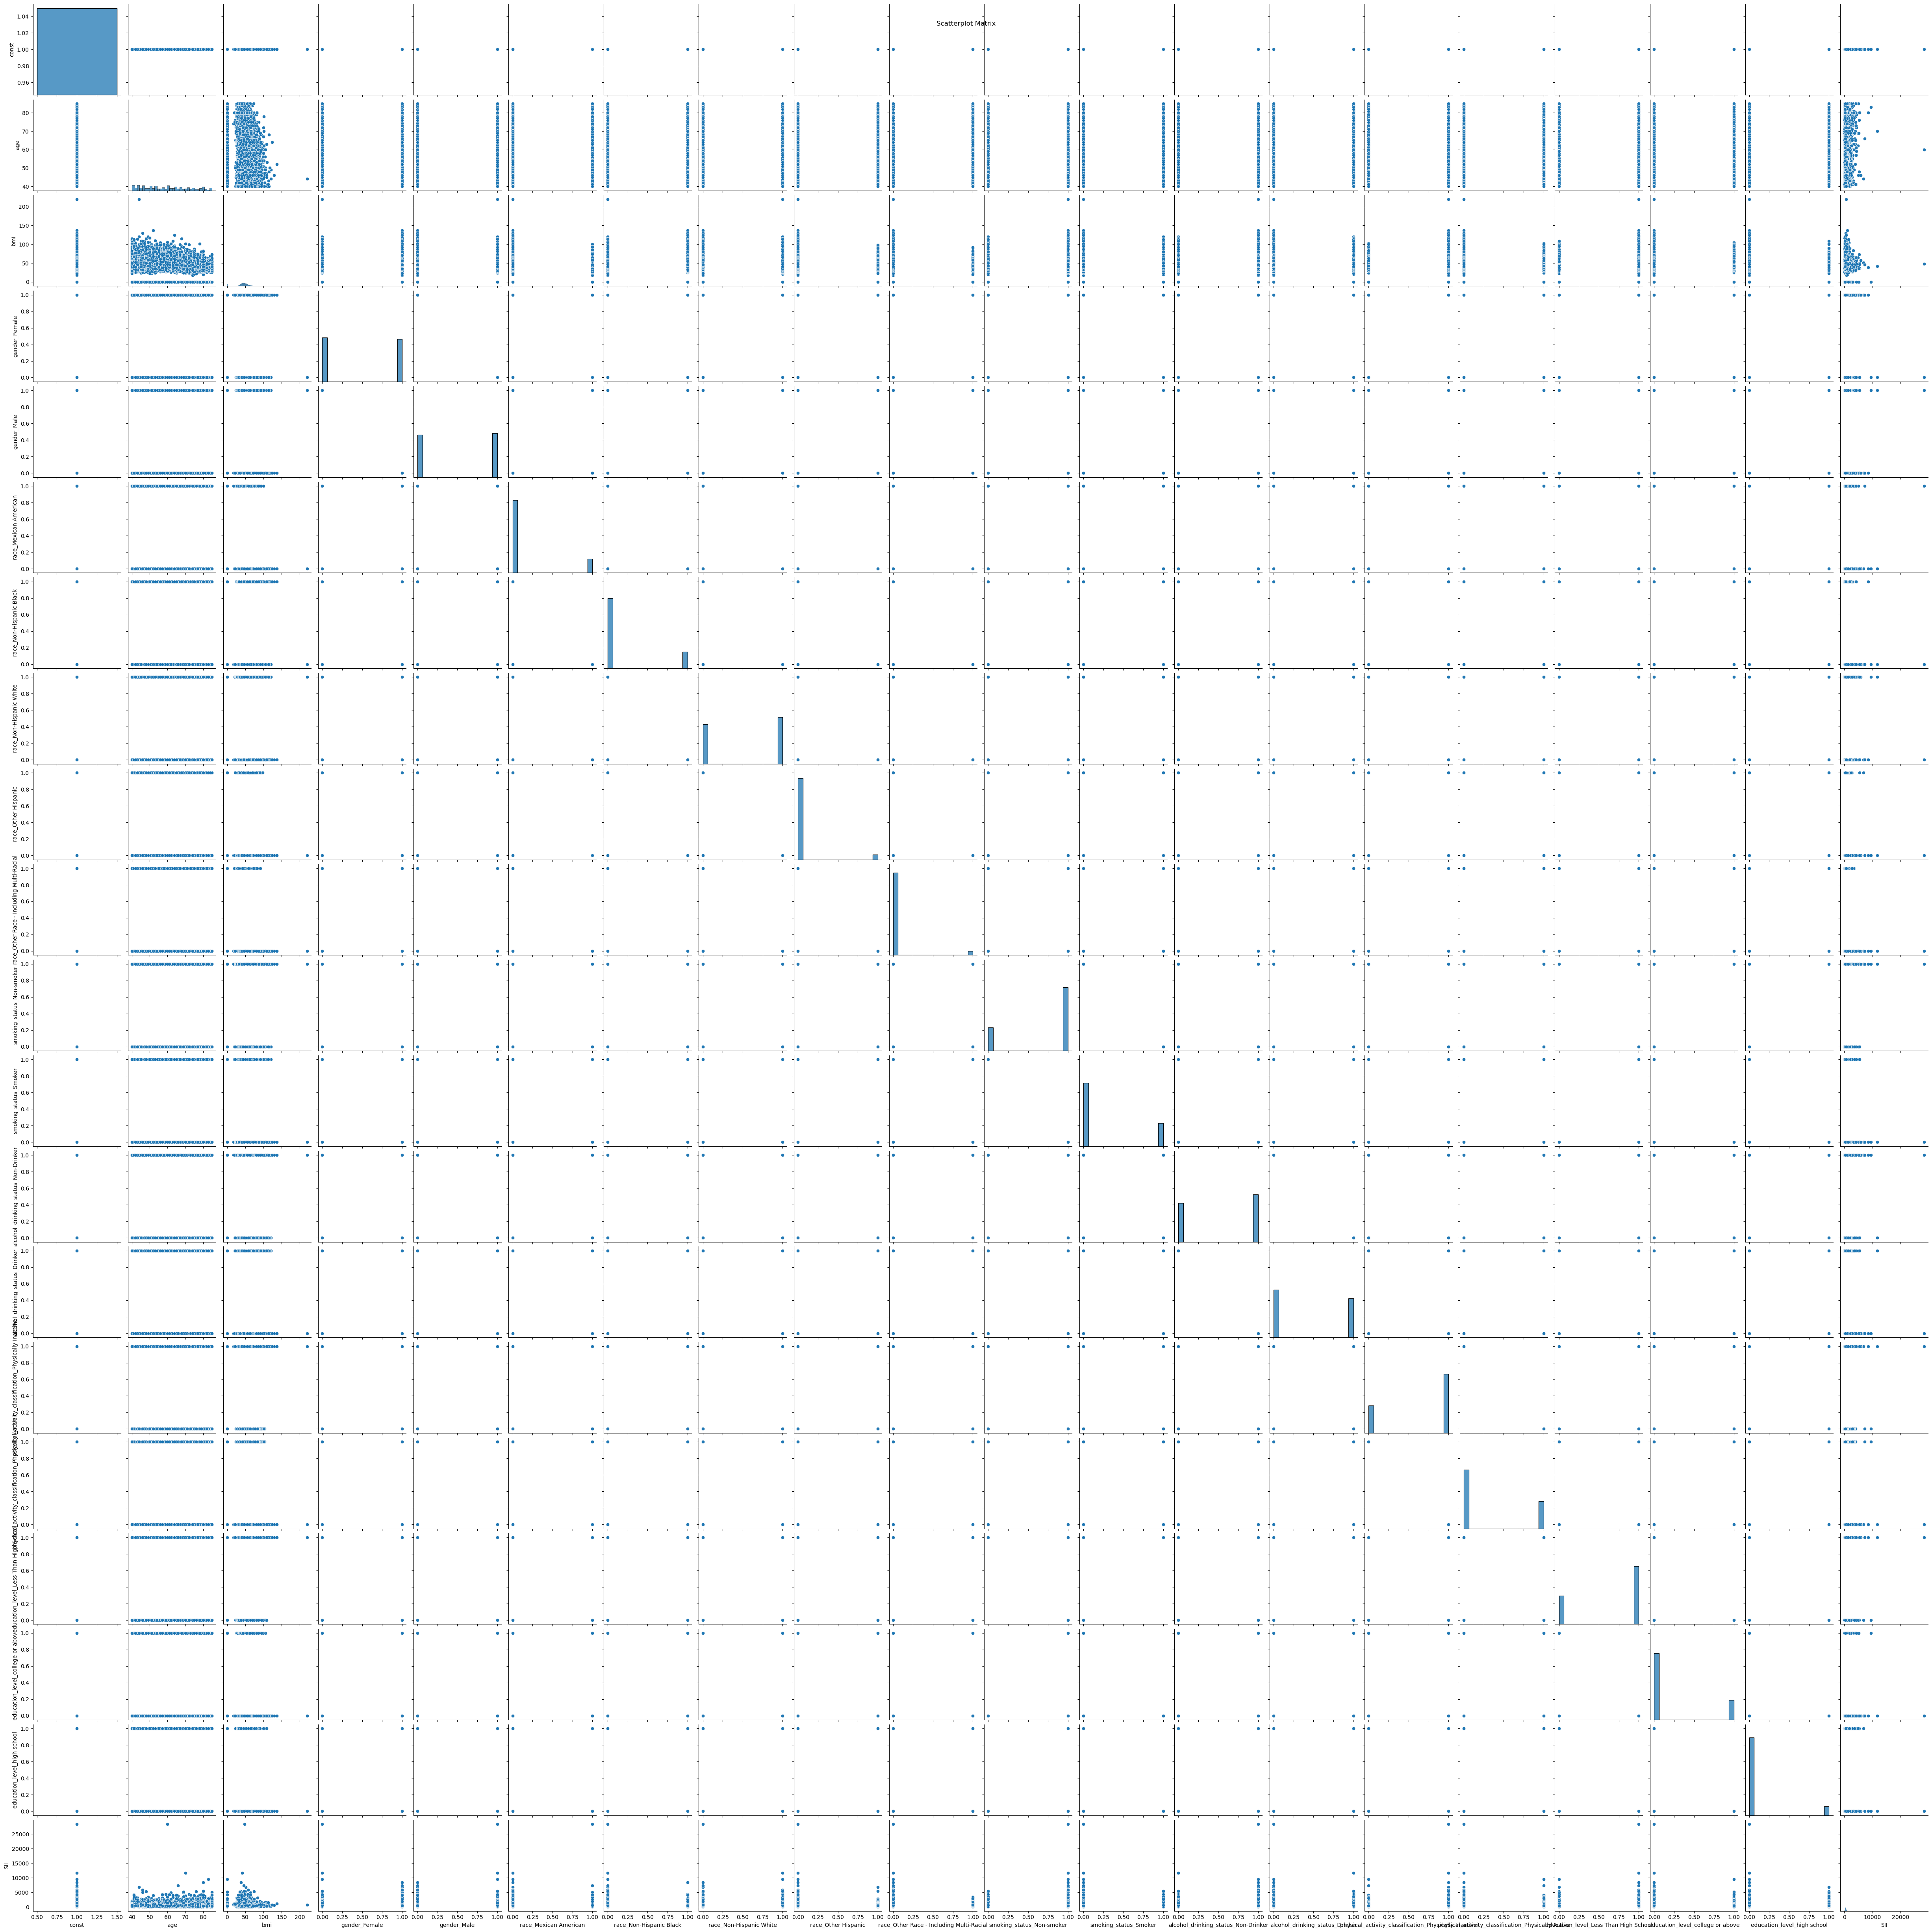

In [413]:
# Scatterplot Matrix
sns.pairplot(data=pd.concat([X, data['SII']], axis=1))
plt.suptitle('Scatterplot Matrix')
plt.show()

## Associations of SII with mortality using Cox Proportional Hazards Regression

In [414]:
data.rename(columns={
    'physical_activity_classification_Physically Active': 'physical_activity_classification_Physically_Active',
    'physical_activity_classification_Physically Inactive': 'physical_activity_classification_Physically_Inactive',
    'smoking_status_Non-smoker': 'smoking_status_Non_smoker',
    'alcohol_drinking_status_Non-Drinker': 'alcohol_drinking_status_Non_Drinker',
    'race_Other Hispanic': 'race_Other_Hispanic',
    'race_Non-Hispanic Black': 'race_Non_Hispanic_Black',
    'race_Mexican American': 'race_Mexican_American',
    'race_Other Race - Including Multi-Racial' : 'race_Other_Race_Including_Multi_Racial',
    'race_Non-Hispanic White': 'race_Non_Hispanic_White'
}, inplace=True)

## Association between high SII group and total mortality

In [415]:
cph = CoxPHFitter()
cph.fit(df, duration_col='permth_exm', event_col='mort_stat', formula='SII_Group + age + bmi + education_level + race + smoking_status + alcohol_drinking_status + physical_activity_classification')

<lifelines.CoxPHFitter: fitted with 28571 total observations, 20594 right-censored observations>

In [416]:
print(cph.summary)

                                                        coef  exp(coef)  \
covariate                                                                 
SII_Group[T.Middle]                                -0.067696   0.934545   
SII_Group[T.High]                                   0.134747   1.144247   
age                                                 0.093956   1.098511   
bmi                                                -0.006497   0.993524   
education_level[T.college or above]                -0.120423   0.886545   
education_level[T.high school]                      0.000211   1.000211   
race[T.Non-Hispanic Black]                          0.407126   1.502494   
race[T.Non-Hispanic White]                          0.235342   1.265342   
race[T.Other Hispanic]                             -0.064332   0.937693   
race[T.Other Race - Including Multi-Racial]         0.004319   1.004328   
smoking_status[T.Smoker]                            0.277326   1.319597   
alcohol_drinking_status[T

<Axes: xlabel='log(HR) (95% CI)'>

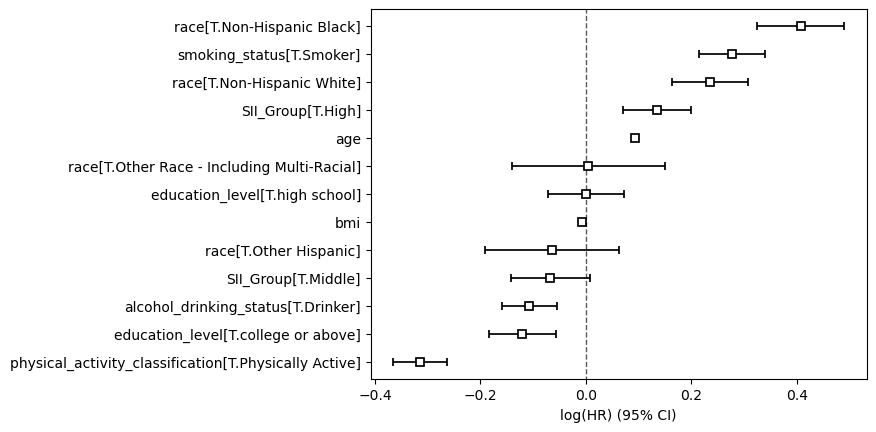

In [417]:
cph.plot()

In [418]:
print('HR for "High" SII_Group:', cph.summary.loc['SII_Group[T.High]', 'exp(coef)'])
print('Lower bound of 95% CI for HR:', cph.summary.loc['SII_Group[T.High]', 'exp(coef) lower 95%'])
print('Upper bound of 95% CI for HR:', cph.summary.loc['SII_Group[T.High]', 'exp(coef) upper 95%'])

HR for "High" SII_Group: 1.1442474624770553
Lower bound of 95% CI for HR: 1.0734819313233082
Upper bound of 95% CI for HR: 1.2196779630665702


Subjects in the **high SII subgroup** had **higher risks of total mortality** [ HR (95% CI) = **1.144247** (1.074482 - 1.219678) ]

## Association between high SII group and CVD mortality

In [420]:
cph_heart_disease = CoxPHFitter()

cph_heart_disease.fit(
    df[(df['ucod_leading'] == 'Diseases of heart') | (df['ucod_leading'] == 'Cerebrovascular disease')], 
    duration_col='permth_exm', 
    event_col='mort_stat', 
    formula='SII_Group + age + bmi + education_level + race + smoking_status + alcohol_drinking_status + physical_activity_classification'
)

print(cph_heart_disease.summary)


                                                        coef  exp(coef)  \
covariate                                                                 
SII_Group[T.Middle]                                -0.002660   0.997344   
SII_Group[T.High]                                   0.076708   1.079727   
age                                                 0.019716   1.019911   
bmi                                                -0.008495   0.991541   
education_level[T.college or above]                -0.197255   0.820981   
education_level[T.high school]                     -0.181565   0.833964   
race[T.Non-Hispanic Black]                          0.308476   1.361349   
race[T.Non-Hispanic White]                          0.273409   1.314438   
race[T.Other Hispanic]                              0.157313   1.170361   
race[T.Other Race - Including Multi-Racial]         0.368277   1.445242   
smoking_status[T.Smoker]                            0.459961   1.584012   
alcohol_drinking_status[T

<Axes: xlabel='log(HR) (95% CI)'>

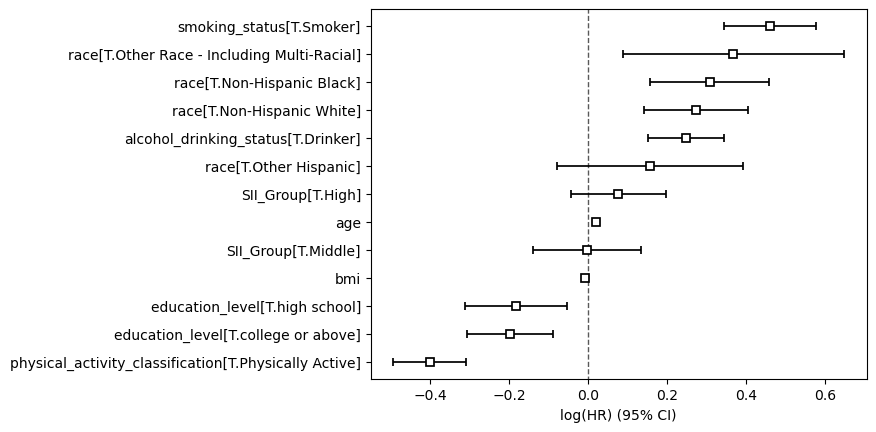

In [421]:
cph_heart_disease.plot()

In [422]:
print('HR for "High" SII_Group:', cph_heart_disease.summary.loc['SII_Group[T.High]', 'exp(coef)'])
print('Lower bound of 95% CI for HR:', cph_heart_disease.summary.loc['SII_Group[T.High]', 'exp(coef) lower 95%'])
print('Upper bound of 95% CI for HR:',cph_heart_disease.summary.loc['SII_Group[T.High]', 'exp(coef) upper 95%'])

HR for "High" SII_Group: 1.0797266091076412
Lower bound of 95% CI for HR: 0.9578789104213913
Upper bound of 95% CI for HR: 1.2170740348612754


Subjects in the **high SII subgroup** had **higher risks of CVD mortality** [ HR (95% CI) = **1.08** (0.96 - 1.22) ]

## Percentage Reduction in Risk Due to Physical Activity

In [424]:
coef_physical_activity = cph.summary.loc['physical_activity_classification[T.Physically Active]', 'coef']
print("Coef of physical activity", coef_physical_activity)

HR = np.exp(coef_physical_activity)

print("(HR) =  exp({:.3f}) = ".format(coef_physical_activity), HR)

percentage_reduction = (HR - 1) * 100

print("Percentage reduction:", percentage_reduction, "%")

Coef of physical activity -0.3139665078979586
(HR) =  exp(-0.314) =  0.730543495186983
Percentage reduction: -26.945650481301698 %


For subjects with a high level of SII, **physical activity** could **attenuate** a separate **27%** risks of total mortality

In [425]:
cvd_coef_physical_activity = cph_heart_disease.summary.loc['physical_activity_classification[T.Physically Active]', 'coef']
print("Coef of physical activity", cvd_coef_physical_activity)

HR = np.exp(cvd_coef_physical_activity)

print("(HR) =  exp({:.3f}) = ".format(cvd_coef_physical_activity), HR)

percentage_reduction = (HR - 1) * 100

print("Percentage reduction:", percentage_reduction, "%")

Coef of physical activity -0.40114808381582207
(HR) =  exp(-0.401) =  0.6695509040435849
Percentage reduction: -33.04490959564151 %


For subjects with a high level of SII, **physical activity** could **attenuate** a separate **33%** risks of CVD mortality